## Tarea 3, parte 2: queries


In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rc
import act4 
rc('font', **{'family':'serif','serif':['Palatino']})
rc('text', usetex=True)
% matplotlib inline

### Problema 1: Un query en SQL 


En el siguiente bloque se guarda en la variable adql el query con el cual se extraen los datos.
Primero, el query extrae información a partir de un link entre las tablas I/337/tgas y I/331/hip2 (esto se realiza mediante los comandos FROM, INNER JOIN y ON). 

A partir de este link, se seleccionan los datos listados despues del comando SELECT, que en este caso son el ID de la fuente en GAIA, GAIA hip, 2 magnitudes (una de gaia y la otra de hipparcos) y el valor de B-V de Hipparcos. Es importante notar que en SELECT se realizan operaciones sobre los datos extraidos; se calculan las magnitudes absolutas (g_mag_abs) a partir de las magnitudes aparentes (phot_g_mean_mag) usando los paralajes de GAIA e Hipparcos.

Después, sobre estos datos, se aplica un filtro que es especificado mediante el comando WHERE. En nuestro caso, cada fila de la tabla extraida debe cumplir con 4 condiciones: la S/N en el paralaje debe ser mayor o igual a 5 (para GAIA e Hipparcos), el error de B-V en Hipparcos de cumplir con $0 < e(B-V) <= 0.05$ y una condición sobre el flujo en la banda G medido pr GAIA. 




In [2]:
tap = "http://tapvizier.u-strasbg.fr/TAPVizieR/tap"

adql = """
SELECT gaia.source_id, gaia.hip,
     gaia.phot_g_mean_mag+5*log10(gaia.parallax)-10 as g_mag_abs_gaia,
     gaia.phot_g_mean_mag+5*log10(hip.plx)-10 as g_mag_abs_hip,
     hip."B-V"
FROM "I/337/tgas" AS gaia
INNER JOIN "I/311/hip2" as hip
ON gaia.hip = hip.HIP
WHERE gaia.parallax/gaia.parallax_error >= 5 AND
hip.Plx/hip.e_Plx >= 5 AND
hip."e_B-V" > 0.0 and hip."e_B-V" <= 0.05 AND
(2.5/log(10))*(gaia.phot_g_mean_flux_error/gaia.phot_g_mean_flux)<= 0.05
"""

In [3]:
# Extraemos la tabla de datos 
data = act4.query_TAP(tap, adql)

/usr/local/lib/python2.7/dist-packages/IPython/kernel/__init__.py:13: ShimWarning: The `IPython.kernel` package has been deprecated. You should import from ipykernel or jupyter_client instead.
  "You should import from ipykernel or jupyter_client instead.", ShimWarning)


El query nos entrega una tabla con 43564 objetos encontrados, cada uno con 5 datos: su ID, el código hip, la magnitud absoluta en la banda G de GAIA e Hipparcos y el valor de B-V. 

In [4]:
print data ,'\n'
print 'Rows:',len(data)

   source_id [1]    hip [1] g_mag_abs_gaia [1] g_mag_abs_hip [1] B-V [1]
                                   mag                mag          mag  
------------------- ------- ------------------ ----------------- -------
6573602993063998848  109795      2.87160300908     2.45642582017   0.631
6573655460384085888  109508      2.60984667835     2.52287954206   0.646
6573729196383276544  109901      5.38885950082      5.2669742502   0.828
6573753591797024000  110115       5.7858514758      5.3050921695   0.965
6573981087624594816  109455      3.69903268771     3.66261809916   0.464
6574012080108969600  109595      3.09765842266     3.60122397773   0.387
6574081349341199872  109489      4.66990623024     4.46511319184   0.763
6574301973221214848  108950      3.45515927014     3.51061357103   0.718
6575069020022983040  108808      3.58897392678     3.59302140682   0.495
6575294797861786112  105929      5.29664017839     5.24325349673   0.755
6575396915005858560  106043      7.99530041096     

/usr/lib/pymodules/python2.7/matplotlib/collections.py:548: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == 'face':


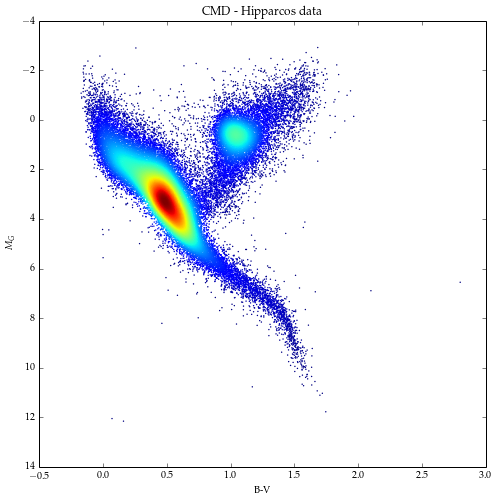

In [5]:
# Extraemos los datos para el CMD
xcol = 'B-V'           # el color
ycol = 'g_mag_abs_hip' # magnitud de Hipparcos
act4.plot_scatter_density(data, xcol, ycol, 'B-V', '$M_G$', 'CMD - Hipparcos data')

### Problema 2: Haciendo queries en SDSS


Sloan Digital Sky Survey (SDSS) es un estudio, iniciado en el 2000, que ha realizado mediciones espectrográficas y fotométricas de más de 3 millones de objetos astronómicos cubriendo aproximadamente un tercio del cielo. Gracias a estas mediciones, SDSS logró realizar un mapeo tridimensional del universo de gran precisión que sirvió para realizar numerosos avances en el conocimiento sobre galaxias, estrellas y quasars. Así, la base de datos de SDSS ha sido una de las más usadas en investigaciones sobre astronomía moderna.

Mediante el siguiente query extraemos datos del *Data Release 8 (DR8)*. Este es un catálogo que contiene todos los datos fotométricos y espectrográficos obtenidos por SDSS durante un año.

Con esta sección del query selecccionamos las columnas que queremos extraer de las tablas. La ascención recta, declinación, la extinción en la banda r y magnitudes (con un modelo, psf y petrosian) en las bandas r, u, g, i, z (también se consideran las magnitudes petrosianas con radios efectivos de 50 y 90) desde la tabla *Galaxy*; el plate number, el modified julian date, el id de la fibra, el redshift y su error, elrChi2, la velocidad de dispersión y su error desde la tabla *SpecObj*; valores de flujo y errores de las líneas de NII 6584, OIII 5007, $H_{\alpha}$ y $H_{\beta}$ desde *GalSpecLine*; información sobre el 4000A break desde *GalSpecIndx*; una media del log total stellar mass, el tipo de galaxia segun las líneas de emisión basado en diagramas BPT y una estimación de la mediana de Log SFR desde *GalSpecExtra*.
 
    SELECT                                                            
     G.ra, G.dec, S.mjd, S.plate, S.fiberID,                           
     S.z, S.zErr, S.rChi2, S.velDisp, S.velDispErr,
     G.extinction_r, G.petroMag_r, G.psfMag_r, G.psfMagErr_r,
     G.modelMag_u, G.modelMagErr_u, G.modelMag_g, G.modelMagErr_g,
     G.modelMag_r, G.modelMagErr_r, G.modelMag_i, G.modelMagErr_i,
     G.modelMag_z, G.modelMagErr_z, G.petroR50_r, G.petroR90_r,
     GSL.nii_6584_flux, GSL.nii_6584_flux_err, GSL.h_alpha_flux,
     GSL.h_alpha_flux_err, GSL.oiii_5007_flux, GSL.oiii_5007_flux_err,
     GSL.h_beta_flux, GSL.h_beta_flux_err,
     GSL.h_delta_flux, 
     GSL.h_delta_flux_err,
     GSX.d4000, GSX.d4000_err, GSE.bptclass,
     GSE.lgm_tot_p50, GSE.sfr_tot_p50, G.objID, GSI.specObjID
     
En el siguiente bloque especificamos que se extraerán datos de *SpecObj*, *Galaxy*, *GalSpecInfo*, *GalSpecLine*, *GalSpecIndx* y *GalSpecExtra*. Además, con la función *dbo.fGetNearestObjEQ*, obtenemos todos los objetos que se encuentren dentro de un círculo en cielo de radio 0.06 arcmin y centrado en las coordenadas de RA y DEC de los objetos de *SpecObj*. 
CROSS APPLY es similar a JOIN, el que se usa para poder extraer datos de más de una tabla. Todos los datos son guardados en mydb.SDSS mediante el comando INTO.
     
    INTO mydb.SDSS FROM SpecObj S CROSS APPLY
     dbo.fGetNearestObjEQ(S.ra, S.dec, 0.06) N, Galaxy G,
     GalSpecInfo GSI, GalSpecLine GSL, GalSpecIndx GSX,
     GalSpecExtra GSE
     
En la primera parte de esta sección del query (N.objID = G.objID) seleccionamos los objetos de la lista que corresponden a las IDs de cada galaxia. Hacemos lo mismo para los datos de GSI, GSL, GSX y GSE donde el match se realiza con la tabla *SpecObj*. Luego se establecen condiciones para las magnitudes de las galaxias, para el rChi2 y para el redshift y su error.

    WHERE N.objID = G.objID
     AND GSI.specObjID = S.specObjID
     AND GSL.specObjID = S.specObjID
     AND GSX.specObjID = S.specObjID
     AND GSE.specObjID = S.specObjID
     AND (G.petroMag_r > 10 AND G.petroMag_r < 18)
     AND (G.modelMag_u - G.modelMag_r) > 0
     AND (G.modelMag_u - G.modelMag_r) < 6
     AND (modelMag_u > 10 AND modelMag_u < 25)
     AND (modelMag_g > 10 AND modelMag_g < 25)
     AND (modelMag_r > 10 AND modelMag_r < 25)
     AND (modelMag_i > 10 AND modelMag_i < 25)
     AND (modelMag_z > 10 AND modelMag_z < 25)
     AND S.rChi2 < 2
     AND (S.zErr > 0 AND S.zErr < 0.01)
     AND S.z > 0.02
     
Referencia: [SQL](http://skyserver.sdss.org/dr12/en/help/howto/search/introduction.aspx), [SDSS](http://www.sdss.org/)     
     

In [6]:
from astropy.io.fits import getdata
data, hdata = getdata('SDSS_enjimenez.fit',1, header = "True")

Para el diagrama BPT necesitamos:

Dato 27: flujo de [NII]

Dato 29: flujo de $H_{\alpha}$

Dato 31: flujo de [OIII]

Dato 33: flujo de $H_{\beta}$

In [7]:
# Extraemos los datos y sus errores
H_a = np.array([data['h_alpha_flux'], data['h_alpha_flux_err']]).T
H_b = np.array([data['h_beta_flux'], data['h_beta_flux_err']]).T
NII = np.array([data['nii_6584_flux'], data['nii_6584_flux_err']]).T
OIII = np.array([data['oiii_5007_flux'], data['oiii_5007_flux_err']]).T
c = np.array([data['ra'], data['dec']]).T # Coordenadas
ids = np.array(data['objID'])  # IDs

In [8]:
# Eliminamos las filas donde H_a ó H_b son ceros
def nonzero (h1, h2, X1, X2, c, ids):
    m = np.nonzero(h1[:,0])[0]
    h1, h2, X1, X2, c, ids = h1[m], h2[m], X1[m], X2[m], c[m], ids[m]
    m = np.nonzero(h2[:,0])[0]
    h1, h2, X1, X2, c, ids = h1[m], h2[m], X1[m], X2[m], c[m], ids[m]
    return h1, h2, X1, X2, c, ids

H_a, H_b, NII, OIII, c, ids = nonzero(H_a, H_b, NII, OIII, c, ids)

In [9]:
# Seleccionamos datos con S/N  > 10
mask = (NII[:,0]/NII[:,1] > 10) & (OIII[:,0]/OIII[:,1] > 10) & (H_a[:,0]/H_a[:,1] > 10) & (H_b[:,0]/H_b[:,1] > 10)
H_a, H_b, NII, OIII, c, ids = H_a[mask], H_b[mask], NII[mask], OIII[mask], c[mask], ids[mask] 

# Calculamos las razones NII/Ha y OIII/Hb
NII_Ha = NII[:,0] / H_a[:,0]
OIII_Hb = OIII[:,0] / H_b[:,0]

In [10]:
# Guardamos los datos para una estrella con emisión de regiones H II y otra con emisión de AGN
m1 = (np.log10(NII_Ha) > 0) & (np.log10(OIII_Hb) > .5)
m2 = (np.log10(NII_Ha) < .5) & (np.log10(OIII_Hb) < 0)

# Elegimos una dato arbitrario (7)
AGN = [(NII_Ha[m1])[7], (OIII_Hb[m1])[7]]
HII = [(NII_Ha[m2])[7], (OIII_Hb[m2])[7]]
ra_AGN, dec_AGN = (c[m1])[7] 
ra_HII, dec_HII = (c[m2])[7]
id_AGN, id_HII = (ids[m1])[7], (ids[m2])[7]

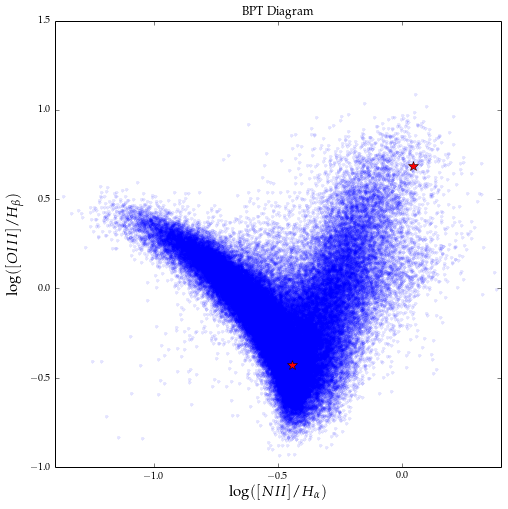

In [11]:
# Graficamos
plt.figure(figsize = [8,8])
plt.plot(np.log10(NII_Ha), np.log10(OIII_Hb), 'b.', alpha = .1)
plt.plot(np.log10(AGN[0]), np.log10(AGN[1]), 'r*', markersize = 10)
plt.plot(np.log10(HII[0]), np.log10(HII[1]), 'r*', markersize = 10)
plt.xlabel('$\log([NII]/H_{\\alpha})$', size = 15)
plt.ylabel('$\log([OIII]/H_{\\beta})$', size = 15)
plt.title('BPT Diagram')

Este es un diagrama Baldwin, Phillips & Terlevich (BPT) que organiza a las galaxias de acuerdo a sus líneas de emisión. En general, dicha comparación se basa en las razones [OIII]/$H_{\beta}$ y $[NII]/H_{\alpha}$; las dos líneas de cada razón tienen longitudes de onda similares. Esto nos entrega evidencia de la formación estelar y con ello información sobre el tipo de galaxia (AGNs,LINERs, normales, etc) donde cada grupo ocupa una sección determinada en el diagrama. 

In [12]:
# A continuación extraeremos los espectros de las dos galaxias (puntos rojos del diagrama) usando astroquery
# El punto rojo que presenta una alta razón de OIII/H_b corresponde a una AGN y la otra a una galaxia normal
# que presenta emisiones normales desde regiones con H II

# IDs de cada galaxia usando SkyCoord 
from astropy import units as u
from astropy.coordinates import SkyCoord
from astroquery.sdss import SDSS

pos_AGN = SkyCoord(ra=ra_AGN*u.degree, dec=dec_AGN*u.degree, frame='icrs')
xid_AGN = SDSS.query_region(pos_AGN, spectro=True)

pos_HII = SkyCoord(ra=ra_HII*u.degree, dec=dec_HII*u.degree, frame='icrs')
xid_HII = SDSS.query_region(pos_HII, spectro=True)

/usr/local/lib/python2.7/dist-packages/astroquery/sdss/__init__.py:28: UserWarning: Experimental: SDSS has not yet been refactored to have its API match the rest of astroquery (but it's nearly there).
  warnings.warn("Experimental: SDSS has not yet been refactored to have its API "


In [13]:
# Para comprobar, vemos que los IDS coinciden
print xid_AGN, 'n'
print 'SDSS ID:',id_AGN ,'\n'
print xid_HII
print 'SDSS ID:',id_HII 

      ra           dec             objid        ... run2d instrument
------------- ------------- ------------------- ... ----- ----------
229.938535969 0.87929047569 1237648705671201105 ...    26       SDSS n
SDSS ID: 1237648705671201105 

      ra           dec             objid        ... run2d instrument
------------- ------------- ------------------- ... ----- ----------
243.689839861 0.34881691489 1237648674532033112 ...    26       SDSS
SDSS ID: 1237648674532033112


In [14]:
# Y extraemos los espectros haciendo un match con los IDs encontrado anteriormente
sp_AGN = SDSS.get_spectra(matches=xid_AGN)
sp_HII = SDSS.get_spectra(matches=xid_HII)

In [15]:
# Función que extrae la longitud de onda y el flujo
def data(hdu):
    c0 = hdu[0].header['coeff0']
    c1 = hdu[0].header['coeff1']
    npix = hdu[1].header['naxis2']
    wave = 10.**(c0 + c1 * np.arange(npix))
    flux = hdu[1].data['flux']
    return wave, flux

hdu_AGN = sp_AGN[0]
hdu_HII = sp_HII[0]

#Flujo y longitud de onda para AGN
AGN_wave, AGN_flux = data(hdu_AGN)

#Flujo y longitud de onda para HII
HII_wave, HII_flux = data(hdu_HII)

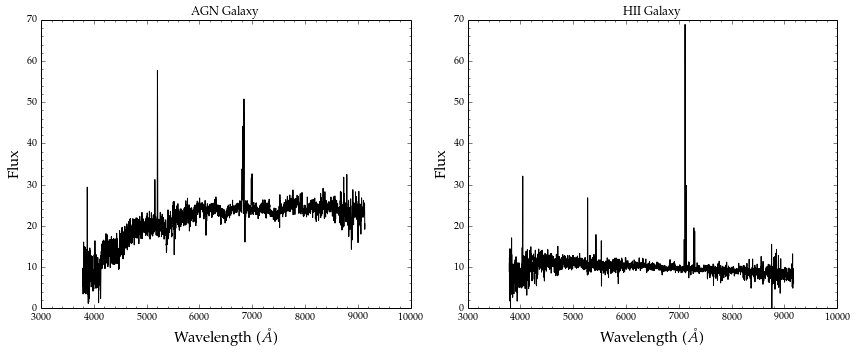

In [16]:
# Espectros
f, ax = plt.subplots(ncols=2, figsize = [12,5])

ax[0].plot(AGN_wave, AGN_flux, 'k-')
ax[0].set_title('AGN Galaxy')
ax[1].plot(HII_wave, HII_flux, 'k-')
ax[1].set_title('HII Galaxy')

for a in ax:
    a.set_ylim(0, 70)
    a.set_xlim(3e3, 1e4)
    a.set_xlabel('Wavelength ($\mathring{A}$)', fontsize=15)
    a.set_ylabel('Flux', fontsize=15)
    a.minorticks_on()
    
f.tight_layout()

### Problema 3: Plots de SDSS spectral templates 

En esta sección analizaremos espectros de SDSS. Para ello descargaremos los spectral templates que son espectros de distintos tipos de estrellas y galaxias. 

In [17]:
# Espectros disponibles
from astroquery.sdss import SDSS
obj = SDSS.AVAILABLE_TEMPLATES
for key in obj:
    print key

star_L1
star_FA
galaxy
star_G
star_F
star_OB
galaxy_lrg
galaxy_late
star_M5
star_M3
star_M1
galaxy_early
qso
star_M8
star_K
star_O
star_B
star_A
star_carbon
qso_bal
star_wd
qso_bright
star_Ksubdwarf


In [18]:
# Líneas principales y sus correspondientes longitud de onda central (galaxias y estrellas)
names = ['K', 'H', 'SII', 'Hd', 'G', 'Hg', 'OIII', 'Hb', 'OIII', 'OIII', 'Mg', 'Na', 'OI', 'OI', 'NII', 'Ha', 'Li',
        'SII','SII', 'CaII', 'CaII', 'CaII']
waves = [3934.777, 3969.588, 4072.3, 4102.89, 4305.61, 4341.68, 4364.436, 4862.68, 4960.295, 5008.240, 5176.7, 5895.6,
        6302.046, 6365.536, 6549.86, 6564.61, 6707.89, 6718.29, 6732.67, 8500.36, 8544.44, 8664.52]

# Lo mismo pero para QSOs
qso_n = ['OVI', 'La', 'OI', 'CII', 'CIV', 'HeII', 'OIII', 'AlIII', 'CIII', 'CII', 'MgII', 'G', 'Hg', 'Hb', 'OIII']
qso_w = [1033.82, 1215.67, 1305.53, 1335.31, 1549.48, 1640.4, 1665.85, 1857.4, 1908.734, 2326.0, 2799.117, 4305.61,
         4341.68, 4862.68, 4960.295] 

Líneas: [Spectro Image SDSS](http://classic.sdss.org/dr7/dm/flatFiles/spSpec.html#hdu2), [Spectral templates](http://classic.sdss.org/dr5/algorithms/spectemplates/)
        

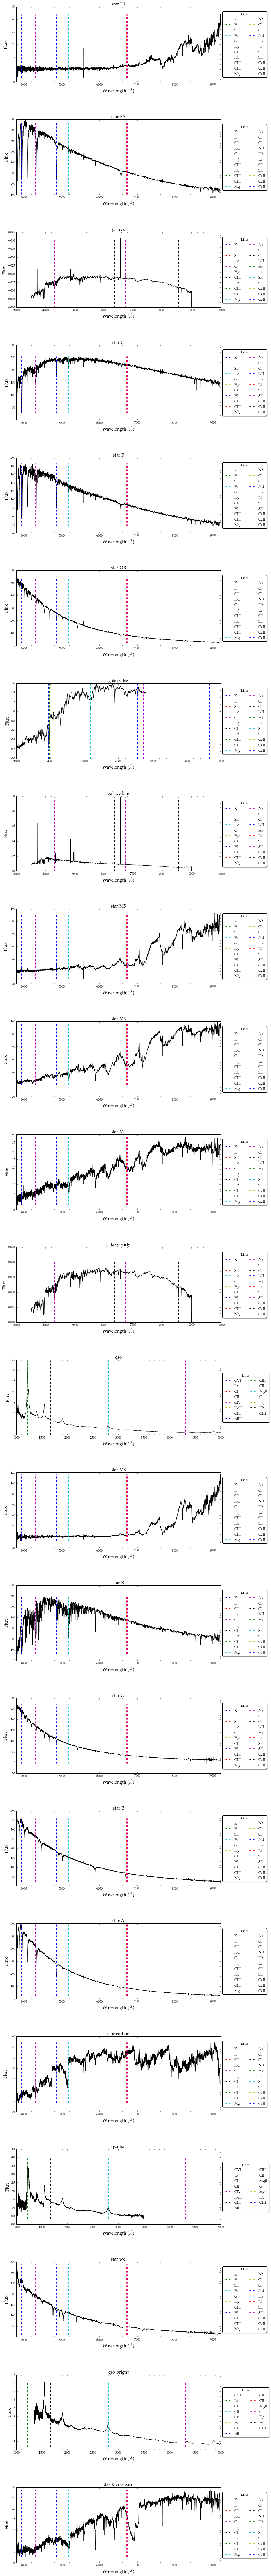

In [19]:
f, ax = plt.subplots(nrows=len(obj), figsize=[12,150])

# Extrae los flujos y las longitudes de onda.
def spectrum(result):
    hdulist = result[0]    
    c0 = hdulist[0].header['coeff0']
    c1 = hdulist[0].header['coeff1']
    npix = hdulist[0].header['naxis1']
    wave = 10.**(c0 + c1 * np.arange(npix))
    flux = hdulist[0].data[0,:]
    return wave, flux

# Plot de las principales líneas de absorción y emisión.
def lines_plot(names, waves, minf, maxf):
    for line, w in zip(names, waves):
        a.plot((w,w), (minf,maxf), '--', label = line)
        
for a, key in zip(ax, obj):
    result = SDSS.get_spectral_template(key)                     
    wave, flux = spectrum(result)                              # Extracción de flujo y longitud de onda
    title = (key.encode('ascii','ignore')).replace("_", " ")   # Guardamos el nombre del objeto
    label = title.split()[0]
    
    a.plot(wave, flux, 'k-')                                   # Plot del espectro
    a.set_title(title, fontsize = 15)
    a.set_xlabel('Wavelength ($\mathring{A}$)', fontsize=15)
    a.set_ylabel('Flux', fontsize=15)
    
    if label == 'star':
        a.set_xlim(3800, 9200)
    
    if label == 'qso':
        lines_plot(qso_n, qso_w, np.min(flux), np.max(flux))   # Plot de líneas para QSOs
        a.set_xlim(1000, 5000)
    
    else:
        lines_plot(names, waves, np.min(flux), np.max(flux))   # Plot de líneas para galaxias y estrellas
        
    box = a.get_position()    
    a.set_position([box.x0, box.y0, box.width * 0.8, box.height])    
    a.legend(loc='center left', title = 'Lines', bbox_to_anchor=(1, 0.5), ncol = 2, fancybox=True, shadow=True)
    a.minorticks_on()
       
f.subplots_adjust(hspace=0.5)